# TP Final - Análisis de Series Temporales - Especialización en Inteligencia Artificial

### Realizar el **análisis espectral** de la serie original. Hallar las frecuencias principales y comparar con las **componentes cíclica y estacional** usando la descomposición.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import boxcox 
from statsmodels.tsa.statespace import sarimax
from scipy import signal
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 
from utiles import LSTMModel, Optimization
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:xlabel='survey_date'>

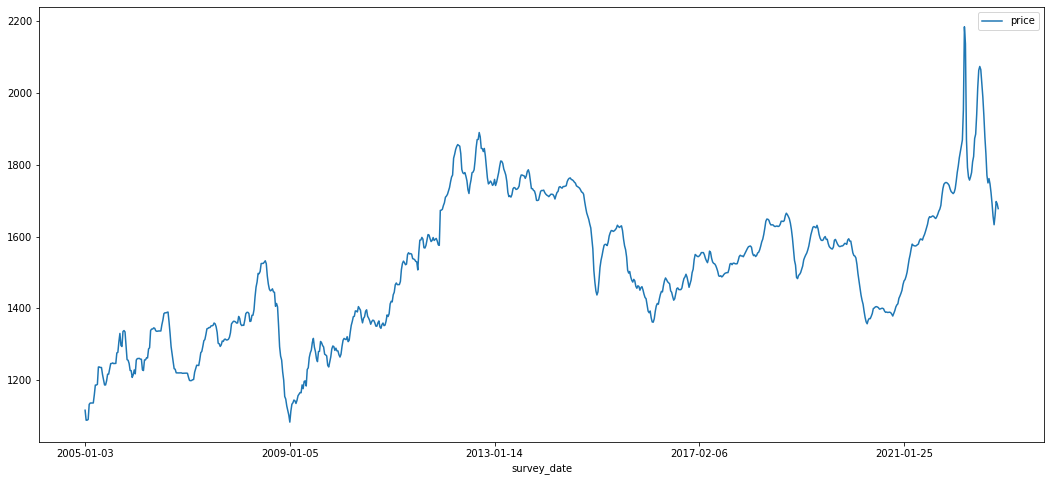

In [307]:
df = pd.read_csv("datasets/weekly_fuel_prices_all_data_from_2005_to_20221102.csv", index_col=0)
df = df.sort_values(by="survey_date")
matplotlib.rcParams['figure.figsize'] = [18,8]
df=df.groupby('product_name')['price'].get_group('Euro-Super 95')
df.plot(legend=True)

In [308]:
ss = StandardScaler()
mm = MinMaxScaler()

In [309]:
df_features = df.copy()
df_features = df_features.reset_index()

df_features = (
                df_features
                .assign(day = pd.to_datetime(df_features['survey_date']).dt.day)
                .assign(month = pd.to_datetime(df_features['survey_date']).dt.month)
                .assign(year = pd.to_datetime(df_features['survey_date']).dt.year)
              )
df_features['order'] = np.arange(len(df_features)) 
df_features.drop(['survey_date'], axis=1, inplace=True)
df_features

,price,day,month,year,order
0,1115.75,3,1,2005,0
1,1088.00,10,1,2005,1
2,1088.14,17,1,2005,2
3,1090.01,24,1,2005,3
4,1132.11,31,1,2005,4
...,...,...,...,...,...
888,1632.81,3,10,2022,888
889,1659.78,10,10,2022,889
890,1697.59,17,10,2022,890
891,1691.24,24,10,2022,891


In [310]:
y = df_features[['price']]
X = df_features.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [311]:
scaler = MinMaxScaler()
X_train_sc = mm.fit_transform(X_train)
X_val_sc = mm.transform(X_val)
X_test_sc = mm.transform(X_test)

y_train_sc = mm.fit_transform(y_train)
y_val_sc = mm.transform(y_val)
y_test_sc = mm.transform(y_test)

In [312]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (571, 4) (571, 1)
Testing Shape (179, 4) (179, 1)


In [313]:
X_train_tensors = Variable(torch.Tensor(X_train.to_numpy()))
X_test_tensors = Variable(torch.Tensor(X_test.to_numpy()))

y_train_tensors = Variable(torch.Tensor(y_train.to_numpy()))
y_test_tensors = Variable(torch.Tensor(y_test.to_numpy())) 

In [314]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [315]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([571, 1, 4]) torch.Size([571, 1])
Testing Shape torch.Size([179, 1, 4]) torch.Size([179, 1])


In [316]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

In [317]:
num_epochs = 10000 #1000 epochs
learning_rate = 0.0001 #0.001 lr

input_size = 4 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [318]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [319]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [320]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
    

Epoch: 0, loss: 2181808.75000
Epoch: 100, loss: 2180801.25000
Epoch: 200, loss: 2179711.00000
Epoch: 300, loss: 2178522.75000
Epoch: 400, loss: 2177317.50000
Epoch: 500, loss: 2176042.25000
Epoch: 600, loss: 2174678.75000
Epoch: 700, loss: 2173210.25000
Epoch: 800, loss: 2171618.50000
Epoch: 900, loss: 2169890.75000
Epoch: 1000, loss: 2168019.00000
Epoch: 1100, loss: 2166000.50000
Epoch: 1200, loss: 2163836.25000
Epoch: 1300, loss: 2161530.00000
Epoch: 1400, loss: 2159087.00000
Epoch: 1500, loss: 2156513.25000
Epoch: 1600, loss: 2153814.75000
Epoch: 1700, loss: 2150995.75000
Epoch: 1800, loss: 2148062.50000
Epoch: 1900, loss: 2145017.75000
Epoch: 2000, loss: 2141866.50000
Epoch: 2100, loss: 2138610.75000
Epoch: 2200, loss: 2135255.00000
Epoch: 2300, loss: 2131801.00000
Epoch: 2400, loss: 2128251.75000
Epoch: 2500, loss: 2124609.50000
Epoch: 2600, loss: 2120876.50000
Epoch: 2700, loss: 2117055.00000
Epoch: 2800, loss: 2113146.50000
Epoch: 2900, loss: 2109152.50000
Epoch: 3000, loss: 210

In [321]:
df.reset_index()

,survey_date,price
0,2005-01-03,1115.75
1,2005-01-10,1088.00
2,2005-01-17,1088.14
3,2005-01-24,1090.01
4,2005-01-31,1132.11
...,...,...
888,2022-10-03,1632.81
889,2022-10-10,1659.78
890,2022-10-17,1697.59
891,2022-10-24,1691.24


In [322]:
df_features_y = df_features_y.reshape(-1,1)

In [326]:
df_features = df_features.to_numpy()

In [327]:
df_X_ss = ss.fit_transform(df_features[:, 1:5]) #old transformers
df_y_mm = mm.fit_transform(df_features_y) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

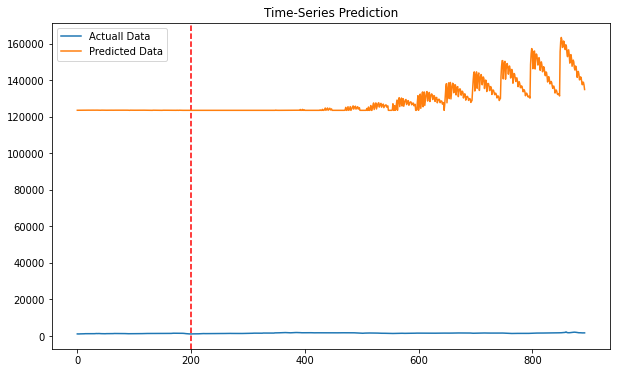

In [328]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 